# ML Classifier Copies - Imbalanced Problem

#### NOTE 

When we talk about imbalance in ML Classifier Copies we are not referring to the balance between classes in the original dataset, but to the intrinsic properties of the classifier.

Since the copy is a priori blind to the original data and original classifier boundaries, the copy classifier is normally build using generated data sampled from the whole space, hence, this process will normally tend to generate many more samples from classes that are described by the classifier as occupying a much larger hypervolume. Therefore, it is the generated data used to train the copy classifier which becomes imbalaced. 

Therefore, "imbalance" refers in this context to problems where each class occupies very different hypervolumes, regardless of the original data available.

<a name="Index">
    
----
# Table of contents

    
1. [**Generated imbalanced problem**](#Problem)
2. [**Fit and evaluate original classifiers**](#Original)
3. [**Imbalanced classifier copies**](#Imbalanced)
    1. [Linear SVC to Decision Tree Classifier (imbalanced)](#SVC2tree_imbalance)
    2. [Decision Tree Classifier to Linear SVC (imbalanced)](#Tree2SVC_imbalance)
4. [**Balanced classifier copies**](#Balanced)
    1. [Linear SVC to Decision Tree Classifier (balanced)](#SVC2tree_balance)
    2. [Decision Tree Classifier to Linear SVC (balanced)](#Tree2SVC_balance)
5. [**Summary of results**](#Results)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

from presc.dataset import Dataset
from presc.copies.copying import ClassifierCopy
from presc.copies.sampling import (dynamical_range, find_categories, build_equal_category_dict,
                                   mixed_data_features, grid_sampling, uniform_sampling, 
                                   normal_sampling, categorical_sampling, mixed_data_sampling, labeling,
                                   sampling_balancer)

[Index](#Index)  
  
  


<a name="Problem">  

-----
-----
# Generated imbalanced problem

#### Small dimensionality (number of features=3).

In [4]:
nsamples = 1000
nproblems = 1
nfeatures = 3
nclasses = 3
scale = 8

class_samples = int(nsamples / nclasses)
t_pred = scale * np.random.normal(0, 1, (class_samples, nfeatures))
df_pred = pd.DataFrame(t_pred)
df_pred["class"] = 0

# Create additional classes centered at `m` with standard deviation `scale`
for i in range(1, nclasses):
    # Generate a normalized vector in a random direction
    v = np.random.normal(0, 1, nfeatures)
    v = v / np.linalg.norm(v)

    # Generate a random distance from the origin to define the center of each gaussian
    alpha = [15,15][i-1]
    m = alpha * v

    # Generate a random scaling for each gaussian
    scale = [0.3,0.3][i-1]

    # Generate normally distributed random samples for this classs
    t = m + scale * np.random.normal(0, 1, (class_samples, nfeatures))
    df = pd.DataFrame(t)
    df["class"] = i

    # Add class data to the dataset
    df_pred = pd.concat([df_pred, df], ignore_index=True)

# Convert into PRESC Dataset
df_presc = Dataset(df_pred, label_col="class")

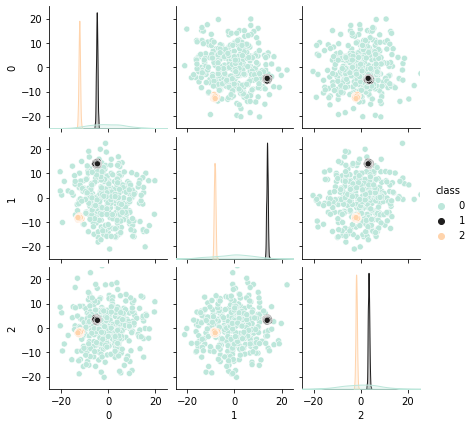

In [5]:
g = sns.pairplot(df_presc.df, vars=[i for i in range(nfeatures)], hue="class", 
                 palette="icefire", height=2).set(xlim=(-25,25), ylim = (-25,25))#, , kind="kde")
plt.show()

### Dynamical range

In [6]:
%%capture
feature_description = dynamical_range(df_presc.features)
feature_description

[Index](#Index)  
  
  


<a name="Original">  

-----
-----
# Fit and evaluate original classifiers

In [55]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(df_presc.features, df_presc.labels, 
                                                    test_size=0.40, random_state=42)
df_train = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], axis=1)
df_test = pd.concat([pd.DataFrame(X_test), pd.DataFrame(y_test)], axis=1)

# Linear SVC Classifier
original_SVC_classifier = SVC(kernel='rbf', decision_function_shape='ovo')
original_SVC_classifier.fit(X_train, y_train)

# Linear SVC Classifier Evaluation
y_predicted_original_SVC = original_SVC_classifier.predict(X_test)
score_original_SVC = original_SVC_classifier.score(X_test, y_test)
report_original_SVC = classification_report(y_test, y_predicted_original_SVC)

# Decision Tree Classifier
original_tree_classifier = DecisionTreeClassifier(max_depth=3)
original_tree_classifier.fit(X_train, y_train)

# Decision Tree Classifier Evaluation
y_predicted_original_tree = original_tree_classifier.predict(X_test)
score_original_tree = original_tree_classifier.score(X_test, y_test)
report_original_tree = classification_report(y_test, y_predicted_original_tree)

print(f"\nNumber of features = {nfeatures:.0f}")
print(f"\nScore of SVC classifier = {score_original_SVC:.4f}")
print("\n", report_original_SVC)
print(f"------------------------------------------------------\n")
print(f"Score of decision tree classifier = {score_original_tree:.4f}")
print("\n", report_original_tree)


Number of features = 3

Score of SVC classifier = 0.9875

               precision    recall  f1-score   support

           0       1.00      0.97      0.98       146
           1       0.97      1.00      0.98       129
           2       0.99      1.00      1.00       125

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400

------------------------------------------------------

Score of decision tree classifier = 0.9975

               precision    recall  f1-score   support

           0       1.00      0.99      1.00       146
           1       0.99      1.00      1.00       129
           2       1.00      1.00      1.00       125

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



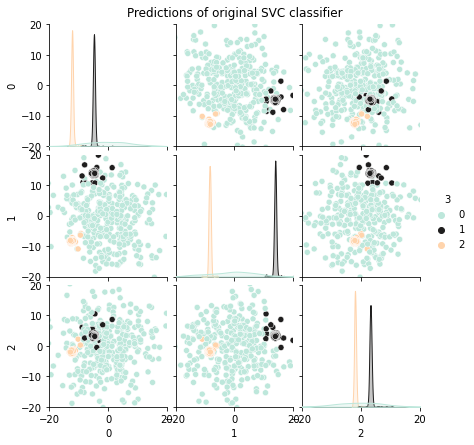

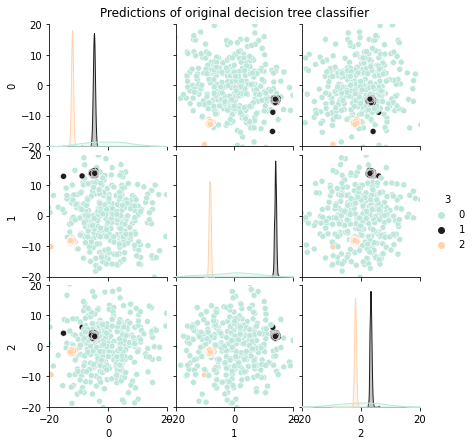

In [56]:
dataset_predicted_tree = Dataset(pd.concat([pd.DataFrame(df_presc.features), 
                                            pd.DataFrame(original_tree_classifier.predict(df_presc.features))], 
                                           axis=1, join="inner", ignore_index=True), label_col=3) 
dataset_predicted_SVC = Dataset(pd.concat([pd.DataFrame(df_presc.features), 
                                            pd.DataFrame(original_SVC_classifier.predict(df_presc.features))], 
                                           axis=1, join="inner", ignore_index=True), label_col=3)
g = sns.pairplot(dataset_predicted_SVC.df, vars=[i for i in range(nfeatures)], hue=3, 
                 palette="icefire", height=2).set(xlim=(-20,20), ylim = (-20,20))
g.fig.suptitle("Predictions of original SVC classifier", y=1.02)
plt.show()
g = sns.pairplot(dataset_predicted_tree.df, vars=[i for i in range(nfeatures)], hue=3, 
                 palette="icefire", height=2).set(xlim=(-20,20), ylim = (-20,20))
g.fig.suptitle("Predictions of original decision tree classifier", y=1.02)
plt.show()

[Index](#Index)  
  
  


<a name="Imbalanced"> 

----
----
# Imbalanced sampling

<a name="SVC2tree_unbalance"> 

### Linear SVC original to Decision Tree copy (imbalanced)

In [103]:
# Create decision tree copy
classifier_copy = DecisionTreeClassifier(max_depth=2)
normal_SVC2tree_copy = ClassifierCopy(original_SVC_classifier, classifier_copy, normal_sampling, nsamples=200, 
                                      random_state=42, feature_parameters=feature_description, label_col="class") 
normal_SVC2tree_training = normal_SVC2tree_copy.copy_classifier(get_training_data=True)

# Copy Evaluaton summary with original test and synthetic test datasets
synthetic_test_data = normal_SVC2tree_copy.generate_synthetic_data(nsamples=200, random_state=43)
evaluation_SVC2tree_imbalanced = normal_SVC2tree_copy.evaluation_summary(test_data=Dataset(df_test, 
                                                 label_col="class"), synthetic_data=synthetic_test_data)

Original Model Accuracy (test)          0.9875
Copy Model Accuracy (test)              0.6750
Empirical Fidelity Error (synthetic)    0.1250
Empirical Fidelity Error (test)         0.3175
Replacement Capability (synthetic)      0.8750
Replacement Capability (test)           0.6835


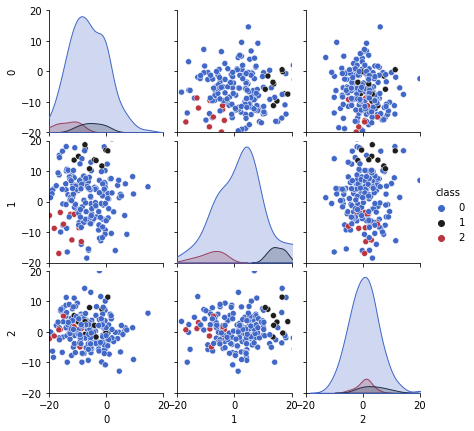

In [105]:
g = sns.pairplot(normal_SVC2tree_training.df, vars=[i for i in range(nfeatures)], hue="class", 
                 palette="icefire", height=2).set(xlim=(-20,20), ylim = (-20,20))
plt.show()

#### Synthetic samples from each class

In [106]:
normal_SVC2tree_training.df.value_counts("class")

class
0    179
2     11
1     10
dtype: int64

[Index](#Index)  
  
  


<a name="Tree2SVC_imbalance"> 

### Decision Tree original to Linear SVC copy (imbalanced)

In [107]:
classifier_copy = SVC(kernel='rbf', decision_function_shape='ovo', gamma=0.01)
normal_tree2SVC_copy = ClassifierCopy(original_tree_classifier, classifier_copy, normal_sampling, nsamples=200, 
                                      random_state=42, feature_parameters=feature_description, label_col="class") 
normal_tree2SVC_training = normal_tree2SVC_copy.copy_classifier(get_training_data=True)

# Copy Evaluaton summary with original test and synthetic test datasets
synthetic_test_data = normal_tree2SVC_copy.generate_synthetic_data(nsamples=200, random_state=43)
evaluation_tree2SVC_imbalanced = normal_tree2SVC_copy.evaluation_summary(test_data=Dataset(df_test, 
                                                    label_col="class"), synthetic_data=synthetic_test_data)

Original Model Accuracy (test)          0.9975
Copy Model Accuracy (test)              0.3650
Empirical Fidelity Error (synthetic)    0.0350
Empirical Fidelity Error (test)         0.6375
Replacement Capability (synthetic)      0.9650
Replacement Capability (test)           0.3659


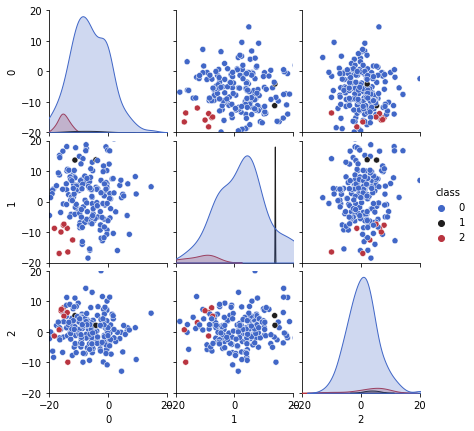

In [109]:
g = sns.pairplot(normal_tree2SVC_training.df, vars=[i for i in range(nfeatures)], hue="class", 
                 palette="icefire", height=2).set(xlim=(-20,20), ylim = (-20,20))
plt.show()

#### Synthetic samples from each class

In [110]:
normal_tree2SVC_training.df.value_counts("class")

class
0    189
2      9
1      2
dtype: int64

[Index](#Index)  
  
  


<a name="Balanced"> 

# Balanced sampling

In [111]:
balance_parameters={"enforce_balance": True, "max_iter": 50, "nbatch": 150, "verbose": False}

<a name="SVC2tree_spherical"> 

### Linear SVC original to Decision Tree copy (balanced)

In [112]:
# Create decision tree copy
classifier_copy = DecisionTreeClassifier(min_samples_leaf=4)
normal_SVC2tree_copy = ClassifierCopy(original_SVC_classifier, classifier_copy, normal_sampling, nsamples=200, 
                                      random_state=42, feature_parameters=feature_description, label_col="class",
                                      **balance_parameters) 
normal_SVC2tree_training = normal_SVC2tree_copy.copy_classifier(get_training_data=True)

# Copy Evaluaton summary with original test and synthetic test datasets
synthetic_test_data = normal_SVC2tree_copy.generate_synthetic_data(nsamples=200, random_state=43)
evaluation_SVC2tree_balanced = normal_SVC2tree_copy.evaluation_summary(test_data=Dataset(df_test, 
                                                label_col="class"), synthetic_data=synthetic_test_data)

Original Model Accuracy (test)          0.9875
Copy Model Accuracy (test)              0.9750
Empirical Fidelity Error (synthetic)    0.0707
Empirical Fidelity Error (test)         0.0125
Replacement Capability (synthetic)      0.9293
Replacement Capability (test)           0.9873


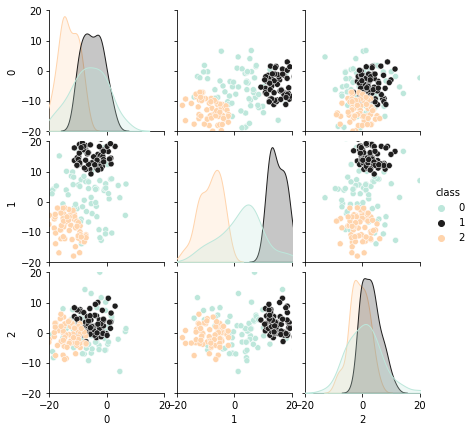

In [114]:
g = sns.pairplot(normal_SVC2tree_training.df, vars=[i for i in range(nfeatures)], hue="class", 
                 palette="icefire", height=2).set(xlim=(-20,20), ylim = (-20,20))
plt.show()

#### Synthetic samples from each class

In [115]:
normal_SVC2tree_training.df.value_counts("class")

class
0    66
1    66
2    66
dtype: int64

[Index](#Index)  
  
  


<a name="Tree2SVC_spherical"> 


### Decision Tree original to Linear SVC copy (balanced)

In [116]:
classifier_copy = SVC(kernel='rbf', decision_function_shape='ovo', gamma=0.01)
normal_tree2SVC_copy = ClassifierCopy(original_tree_classifier, classifier_copy, normal_sampling, nsamples=200, 
                                      random_state=42, feature_parameters=feature_description, label_col="class",
                                      **balance_parameters) 
normal_tree2SVC_training = normal_tree2SVC_copy.copy_classifier(get_training_data=True)

# Copy Evaluaton summary with original test and synthetic test datasets
synthetic_test_data = normal_tree2SVC_copy.generate_synthetic_data(nsamples=200, random_state=43)
evaluation_tree2SVC_balanced = normal_tree2SVC_copy.evaluation_summary(test_data=Dataset(df_test, 
                                                        label_col="class"), synthetic_data=synthetic_test_data)

Original Model Accuracy (test)          0.9975
Copy Model Accuracy (test)              0.9775
Empirical Fidelity Error (synthetic)    0.0455
Empirical Fidelity Error (test)         0.0200
Replacement Capability (synthetic)      0.9545
Replacement Capability (test)           0.9799


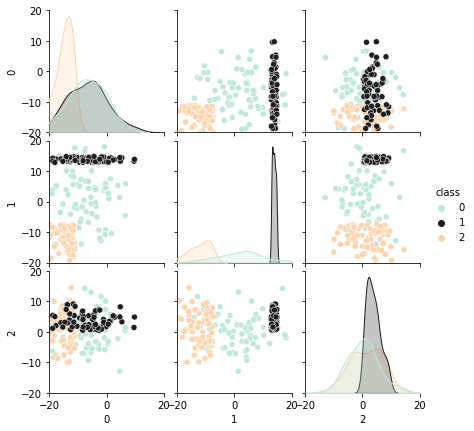

In [118]:
g = sns.pairplot(normal_tree2SVC_training.df, vars=[i for i in range(nfeatures)], hue="class", 
                 palette="icefire", height=2).set(xlim=(-20,20), ylim = (-20,20))
plt.show()

#### Synthetic samples from each class

In [119]:
normal_tree2SVC_training.df.value_counts("class")

class
0    66
1    66
2    66
dtype: int64

[Index](#Index)  
  
  


<a name="Results">

----
## Results summary

Clearly, using the balancing option for the sampler yields better results than not using them:

In [120]:
evaluation_SVC2tree_imbalanced

{'Original Model Accuracy (test)': 0.9875,
 'Copy Model Accuracy (test)': 0.675,
 'Empirical Fidelity Error (synthetic)': 0.125,
 'Empirical Fidelity Error (test)': 0.3175,
 'Replacement Capability (synthetic)': 0.875,
 'Replacement Capability (test)': 0.6835443037974683}

In [121]:
evaluation_SVC2tree_balanced

{'Original Model Accuracy (test)': 0.9875,
 'Copy Model Accuracy (test)': 0.975,
 'Empirical Fidelity Error (synthetic)': 0.07070707070707072,
 'Empirical Fidelity Error (test)': 0.012499999999999956,
 'Replacement Capability (synthetic)': 0.9292929292929293,
 'Replacement Capability (test)': 0.9873417721518987}

In [99]:
evaluation_tree2SVC_imbalanced

{'Original Model Accuracy (test)': 0.9975,
 'Copy Model Accuracy (test)': 0.365,
 'Empirical Fidelity Error (synthetic)': 0.08999999999999997,
 'Empirical Fidelity Error (test)': 0.6375,
 'Replacement Capability (synthetic)': 0.91,
 'Replacement Capability (test)': 0.3659147869674185}

In [100]:
evaluation_tree2SVC_balanced

{'Original Model Accuracy (test)': 0.9975,
 'Copy Model Accuracy (test)': 0.965,
 'Empirical Fidelity Error (synthetic)': 0.07070707070707072,
 'Empirical Fidelity Error (test)': 0.03249999999999997,
 'Replacement Capability (synthetic)': 0.9292929292929293,
 'Replacement Capability (test)': 0.9674185463659147}

[Index](#Index)  
  
  

----